In [2]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph
import matplotlib.pyplot as plt

In [3]:
# hint: you can refer facebook case study notebook to solve this assignment in couple of hours
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [4]:
edges = [tuple(x) for x in data.values.tolist()]

Using stellergaph and gensim packages, get the dense representation(128dimensional vector) of every node in the graph

In [5]:
# 2.using stellergaph and gensim packages, get the dense representation(128dimensional vector) of every node in the graph
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [6]:
A = list(nx.connected_component_subgraphs(B))[0]

In [11]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))

In [12]:
# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [13]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)

In [14]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [16]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [18]:
movie_nodes = node_embeddings[:len(movies)]
actor_nodes = node_embeddings[len(movies):]

In [20]:
from sklearn.cluster import KMeans

In [161]:
no_of_clusters = [3,4, 10, 30, 50, 100, 200, 500]
for curr_cluster in no_of_clusters:
    clf = KMeans(curr_cluster,init='k-means++')
    clf.fit(actor_nodes)
    labels = clf.labels_
    cost_1 = 0
    max_of_actor_nodes=0
    cost_3=0
    for cluster in range(curr_cluster):
        indexes = [len(movies)+i for i,x in enumerate(labels==cluster) if x]
        # Gets the nodes present in current cluster
        nodes_in_curr_cluster = [walks[index][0] for index in indexes]
        # Gets the maximum of actor nodes in curr cluster
        max_of_actor_nodes = max(max_of_actor_nodes,len(nodes_in_curr_cluster))
        # Combines the graph to form whole graph, containing all nodes in current cluster
        final_graph = nx.Graph()
        for node in nodes_in_curr_cluster:
            temp = nx.generators.ego.ego_graph(B,node)
            final_graph = nx.compose(final_graph,temp)
        # Gets the length of largest connected component
        largest_cc = len(max(nx.connected_components(final_graph), key=len))
        # Return no of nodes present in current cluster's graph
        total_nodes_in_curr_cluster = len(final_graph.nodes)
        cost_1 = cost_1 + largest_cc/total_nodes_in_curr_cluster
        # Returns degree of actor nodes in current cluster
        degree_of_nodes_in_curr_cluster = sum(dict(nx.degree(final_graph,nodes_in_curr_cluster)).values())
        # Movie nodes in curr cluster
        no_of_movie_nodes = len(final_graph.nodes)-len(nodes_in_curr_cluster) 
        cost_3 = cost_3 + degree_of_nodes_in_curr_cluster/no_of_movie_nodes
        #print(len(final_graph.nodes))
    cost_1=cost_1/curr_cluster   # Gets the final calculated cost1
    x = max_of_actor_nodes/len(actor_nodes)
    cost_2=x*(1-x)                 # Gets the final calculated cost2
    cost_3 =cost_3/len(nodes_in_curr_cluster) # Gets the final calculated cost3
    print("Current cluster = ",curr_cluster)
    print(cost_1*cost_2*cost_3)

Current cluster =  3
0.0024455100240586354
Current cluster =  4
0.008707682402539083
Current cluster =  10
0.019775740724572364
Current cluster =  30
0.04791926044653362
Current cluster =  50
0.10808856950248011
Current cluster =  100
0.20535595107790308
Current cluster =  200
0.08836992581637429
Current cluster =  500
4.105609733811664


# Observation
1. Choosing no of cluster = 500, as cost is maximum here

In [167]:
from sklearn.manifold import TSNE

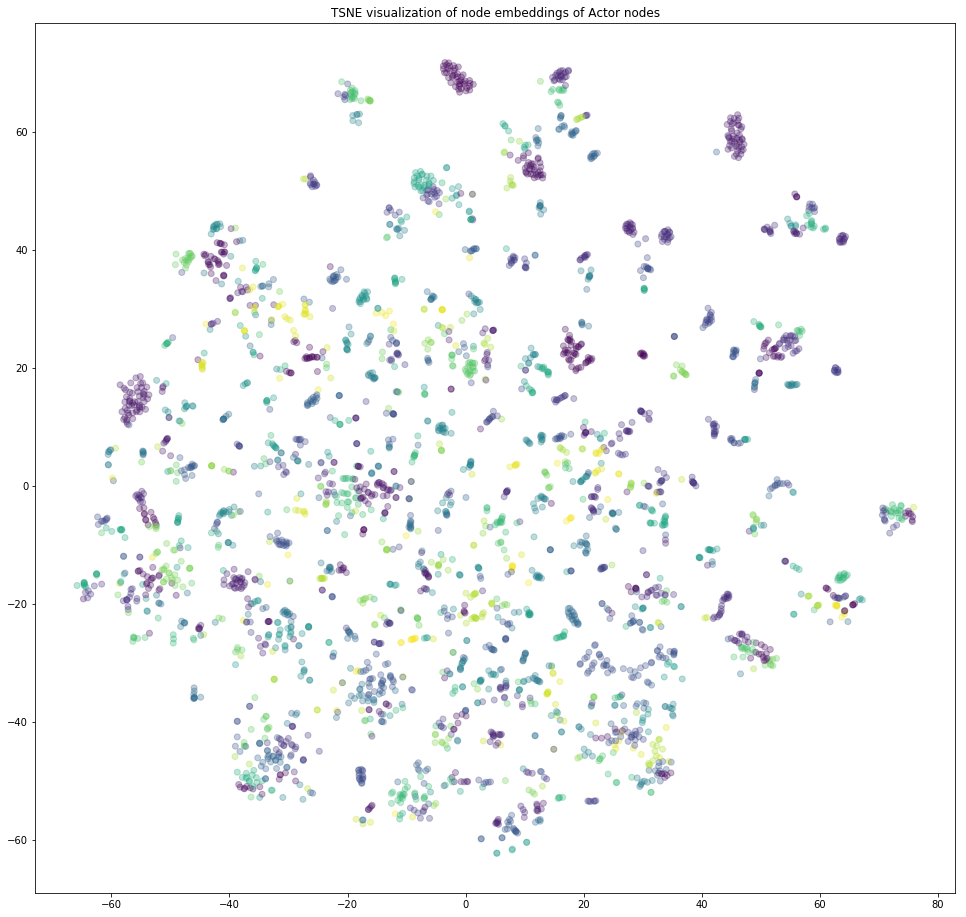

In [181]:
clf_actors = KMeans(n_clusters=500,init='k-means++')
clf_actors.fit(actor_nodes)
labels_of_each_node = clf_actors.labels_
transform = TSNE #PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(actor_nodes)
# draw the points

#label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
#node_colours = [ label_map[target] for target in node_targets]
node_colours = labels_of_each_node
plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, alpha=0.3)
plt.title('{} visualization of node embeddings of Actor nodes'.format(transform.__name__))

plt.show()

Considering movie nodes only

In [177]:
no_of_clusters = [3,4, 10, 30, 50, 100, 200, 500]
for curr_cluster in no_of_clusters:
    clf = KMeans(curr_cluster,init='k-means++')
    clf.fit(movie_nodes)
    labels = clf.labels_
    cost_1 = 0
    max_of_movie_nodes=0
    cost_3=0
    for cluster in range(curr_cluster):
        indexes = [i for i,x in enumerate(labels==cluster) if x]
        # Gets the nodes present in current cluster
        nodes_in_curr_cluster = [walks[index][0] for index in indexes]
        # Gets the maximum of movie nodes in curr cluster
        max_of_movie_nodes = max(max_of_movie_nodes,len(nodes_in_curr_cluster))
        # Combines the graph to form whole graph, containing all nodes in current cluster
        final_graph = nx.Graph()
        for node in nodes_in_curr_cluster:
            temp = nx.generators.ego.ego_graph(B,node)
            final_graph = nx.compose(final_graph,temp)
        # Gets the length of largest connected component
        largest_cc = len(max(nx.connected_components(final_graph), key=len))
        # Return no of nodes present in current cluster's graph
        total_nodes_in_curr_cluster = len(final_graph.nodes)
        cost_1 = cost_1 + largest_cc/total_nodes_in_curr_cluster
        # Returns degree of actor nodes in current cluster
        degree_of_nodes_in_curr_cluster = sum(dict(nx.degree(final_graph,nodes_in_curr_cluster)).values())
        # Actor nodes in curr cluster
        no_of_actor_nodes = len(final_graph.nodes)-len(nodes_in_curr_cluster) 
        cost_3 = cost_3 + degree_of_nodes_in_curr_cluster/no_of_actor_nodes
        #print(len(final_graph.nodes))
    cost_1=cost_1/curr_cluster   # Gets the final calculated cost1
    x = max_of_movie_nodes/len(movie_nodes)
    cost_2=x*(1-x)                 # Gets the final calculated cost2
    cost_3 =cost_3/len(nodes_in_curr_cluster) # Gets the final calculated cost3
    print("Current cluster = ",curr_cluster)
    print(cost_1*cost_2*cost_3)

Current cluster =  3
0.002689411629442732
Current cluster =  4
0.005907895979530675
Current cluster =  10
0.02491569109276973
Current cluster =  30
2.2259428689203022
Current cluster =  50
0.028312173693092177
Current cluster =  100
1.6068935423876303
Current cluster =  200
7.921160567761648
Current cluster =  500
0.4415531057355896


# Observation
Considering n_clusters=200, as cost is maximum here

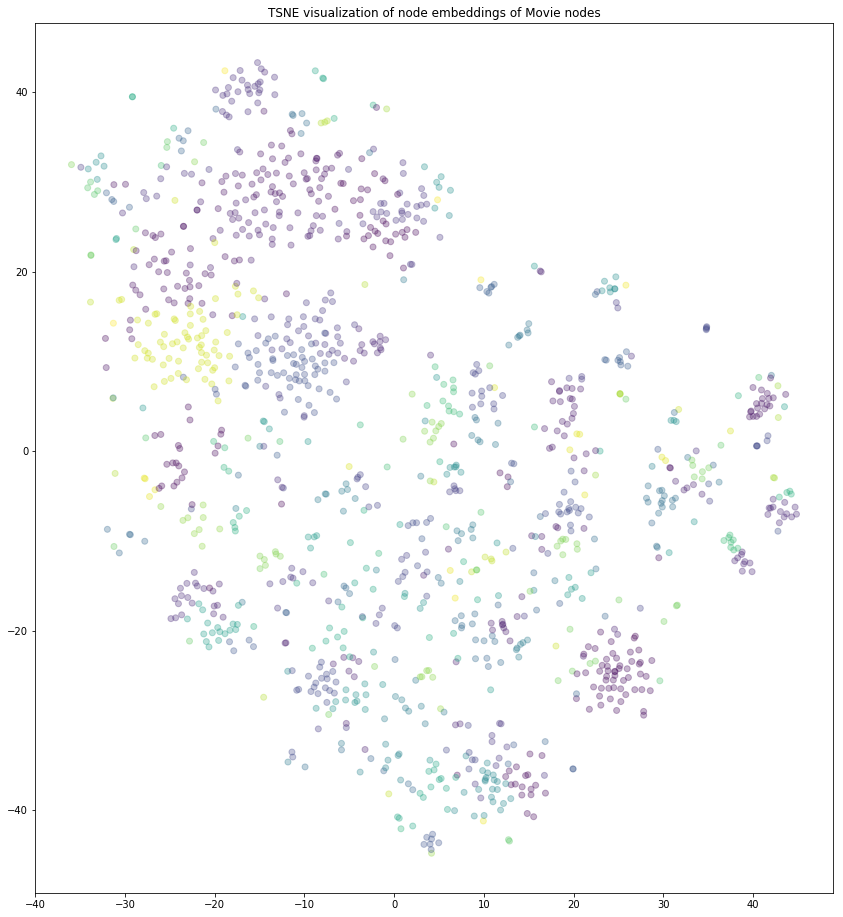

In [180]:
clf_movies = KMeans(n_clusters=200,init='k-means++')
clf_movies.fit(movie_nodes)
labels_of_each_node = clf_movies.labels_
transform = TSNE #PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(movie_nodes)
# draw the points
node_colours = labels_of_each_node
plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, alpha=0.3)
plt.title('{} visualization of node embeddings of Movie nodes'.format(transform.__name__))

plt.show()